In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate, GlobalAveragePooling2D, Activation, Lambda
)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [ ]:
# Local Response Normalization qatını yaradırıq
def lrn(x):
    return tf.nn.local_response_normalization(x)

In [ ]:
def build_model(input_shape=(224, 224, 3), num_classes=38):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Lambda(lrn)(x)

    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = Lambda(lrn)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Block 2 Inception
    conv1 = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    conv5 = Conv2D(32, (5, 5), padding='same', activation='relu')(x)
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    inception_output = concatenate([conv1, conv3, conv5, pool_proj], axis=-1)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(inception_output)

    # Output 0 (early)
    x0 = GlobalAveragePooling2D()(x)
    x0 = Dense(256, activation='relu')(x0)
    softmax0 = Dense(num_classes, activation='softmax', name='softmax0')(x0)

    # Block 3 (daha dərin)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Output 1 (orta çıxış)
    x1 = GlobalAveragePooling2D()(x)
    x1 = Dense(256, activation='relu')(x1)
    softmax1 = Dense(num_classes, activation='softmax', name='softmax1')(x1)

    # Block 4 (son)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)

    # Output 2 (əsas çıxış)
    x = Dense(512, activation='relu')(x)
    softmax2 = Dense(num_classes, activation='softmax', name='softmax2')(x)

    model = Model(inputs=inputs, outputs=[softmax0, softmax1, softmax2])
    return model


In [ ]:
# Modeli qur
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 56, 56,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 56, 56,    │          0 │ conv2d_2[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ lambda_1[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    221,312 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │    153,632 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 416)              │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0],   │
│                     │                   │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 416)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 14,    │    479,360 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 14, 14,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                 

 Total params: 2,334,290 (8.90 MB)

 Trainable params: 2,334,290 (8.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss={
        'softmax0': 'categorical_crossentropy',
        'softmax1': 'categorical_crossentropy',
        'softmax2': 'categorical_crossentropy'
    },
    loss_weights={
        'softmax0': 0.3,
        'softmax1': 0.3,
        'softmax2': 1.0
    },
    metrics=['accuracy', 'accuracy', 'accuracy']
)

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"qasmovdyant","key":"4d4759066dca189587bcac8981b34740"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors


In [ ]:
import zipfile
import os

zip_path = "/content/new-plant-diseases-dataset.zip"
extract_path = "/content/plant_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/plant_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/content/plant_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

# Şəkilləri normallaşdırırıq və lazım olsa augmentasiya edirik
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
def multi_output_generator(generator):
    while True:
        x, y = next(generator)
        yield x, {
            'softmax0': y,
            'softmax1': y,
            'softmax2': y
        }

train_multi = multi_output_generator(train_gen)
valid_multi = multi_output_generator(valid_gen)


In [ ]:
steps_per_epoch = train_gen.samples // train_gen.batch_size
validation_steps = valid_gen.samples // valid_gen.batch_size

history = model.fit(
    train_multi,
    validation_data=valid_multi,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10
)


Epoch 1/10
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 204s 86ms/step - loss: 4.9910 - softmax0_accuracy: 0.1013 - softmax0_loss: 3.2738 - softmax1_accuracy: 0.1291 - softmax1_loss: 3.1581 - softmax2_accuracy: 0.1497 - softmax2_loss: 3.0614 - val_loss: 2.0518 - val_softmax0_accuracy: 0.4916 - val_softmax0_loss: 1.6951 - val_softmax1_accuracy: 0.6144 - val_softmax1_loss: 1.2736 - val_softmax2_accuracy: 0.6358 - val_softmax2_loss: 1.1612
Epoch 2/10
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 187s 81ms/step - loss: 1.4654 - softmax0_accuracy: 0.6075 - softmax0_loss: 1.3007 - softmax1_accuracy: 0.7055 - softmax1_loss: 0.9451 - softmax2_accuracy: 0.7485 - softmax2_loss: 0.7919 - val_loss: 0.9627 - val_softmax0_accuracy: 0.7628 - val_softmax0_loss: 0.7679 - val_softmax1_accuracy: 0.8029 - val_softmax1_loss: 0.6067 - val_softmax2_accuracy: 0.8218 - val_softmax2_loss: 0.5503
Epoch 3/10
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 204s 93ms/step - loss: 0.6997 - softmax0_accuracy: 0.8106 - softmax0_loss: 0.6124 - softmax1_accuracy: 0

In [ ]:
!wget https://raw.githubusercontent.com/databyhuseyn/DeepLearning/refs/heads/main/helper_functions.py

--2025-04-23 21:08:57--  https://raw.githubusercontent.com/databyhuseyn/DeepLearning/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-23 21:08:58 (99.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import plot_loss_curves, unzip_data

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Assuming you want to plot accuracy for the 'softmax2' output
  accuracy = history.history['softmax2_accuracy']
  val_accuracy = history.history['val_softmax2_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

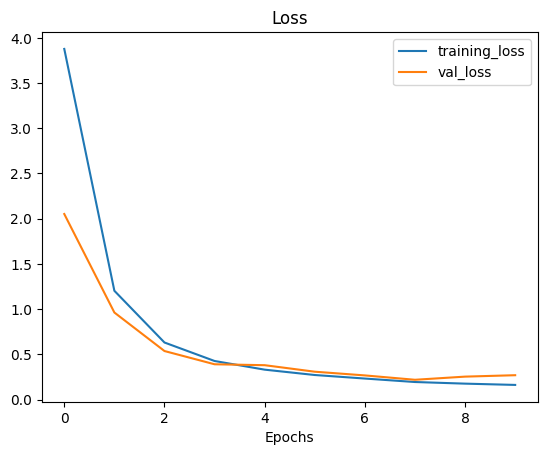

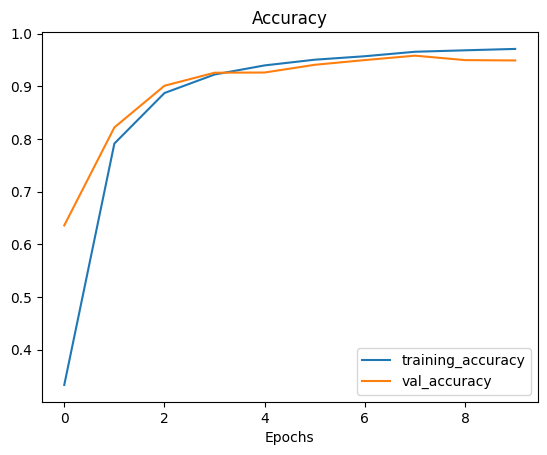

In [ ]:
plot_loss_curves(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


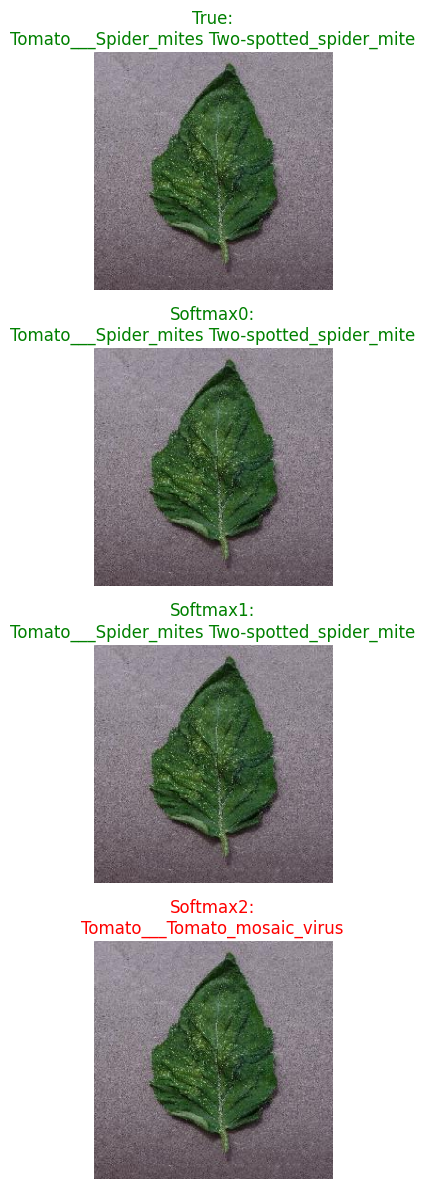

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Class adlarını alırıq
class_indices = train_gen.class_indices
class_labels = list(class_indices.keys())

# Validation-dan bir batch götürək
x_batch, y_batch = next(valid_gen)

# Random index seç
i = random.randint(0, len(x_batch) - 1)

# Proqnoz et
preds = model.predict(np.expand_dims(x_batch[i], axis=0))  # tək şəkil

# Hər çıxış üçün class prediksiya et
pred_classes = [np.argmax(preds[j][0]) for j in range(3)]
true_label = np.argmax(y_batch[i])

# Vizualizasiya: 1 orijinal + 3 çıxış (alt-alta)
plt.figure(figsize=(4, 12))

# Orijinal şəkil
plt.subplot(4, 1, 1)
plt.imshow(x_batch[i])
plt.axis('off')
plt.title(f"True:\n{class_labels[true_label]}", color="green")

# 3 çıxış üçün nəticələr
for j in range(3):
    plt.subplot(4, 1, j + 2)
    plt.imshow(x_batch[i])
    plt.axis('off')
    plt.title(
        f"Softmax{j}:\n{class_labels[pred_classes[j]]}",
        color="green" if pred_classes[j] == true_label else "red"
    )

plt.tight_layout()
plt.show()
